C:\Users\r.hosseinzadeh\AppData\Local\Programs\Python\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


          Person             Guaranteed By
0   Ms Shahriari    Ms Noghli, Ms Khoshdel
1      Ms Noghli    Ms Khoshdel, Ms Salehi
2    Ms Khoshdel       Ms Dehgani, Alireza
3     Ms Dehgani   Ms Shahriari, Ms Noghli
4      Ms Salehi            Reza, Souroush
5           Reza           Souroush, Javad
6         Madjid  Ms Shahriari, Ms Dehgani
7        Alireza           Ms Salehi, Reza
8       Souroush                          
9          Javad                    Madjid
10        Mr Kia                   Alireza


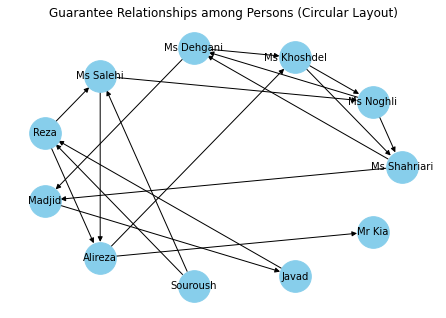

Objective value: 18.0


In [45]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Names of the persons
person_names = ["Ms Shahriari", "Ms Noghli", "Ms Khoshdel", 
                "Ms Dehgani", "Ms Salehi", "Reza", 
                "Madjid", "Alireza", "Souroush", 
                "Javad","Mr Kia"]

# Create a binary linear programming problem
prob = pulp.LpProblem("Guarantee Problem", pulp.LpMinimize)

# Define binary variables
persons = 11
x = [[pulp.LpVariable(f"x_{i}_{j}", cat=pulp.LpBinary) for j in range(persons)] for i in range(persons)]

# Define objective: Minimize the total number of guarantees assigned
objective = pulp.lpSum(x[i][j] for i in range(persons) for j in range(persons))
prob += objective

# Constraints: Each person guarantees at most 2 others
for i in range(persons):
    prob += pulp.lpSum(x[i][j] for j in range(persons)) <= 2
    prob += x[i][i] == 0  # No person can guarantee themselves

# Constraints: Each person is guaranteed by exactly 2 others
for j in range(8):
    prob += pulp.lpSum(x[i][j] for i in range(persons)) == 2
    

# Additional constraints 

# Mr kia
prob += pulp.lpSum(x[10]) == 0  # Person 10 can not guarantee any person
prob += pulp.lpSum(x[i][10] for i in range(persons)) == 1  # Person 10 can only be guaranteed by 1 persons
prob += x[7][10] == 1

#Javad
prob += pulp.lpSum(x[9]) == 1  # Person 9 can only guarantee 1 person
prob += pulp.lpSum(x[i][9] for i in range(persons)) ==1  # Person 10 can only be guaranteed by 0 persons
prob += x[9][5] == 1
prob += x[6][9] == 1

# Done Links
prob += x[1][0] == 1
prob += x[2][0] == 1
prob += x[2][1] == 1
prob += x[7][2] == 1
prob += x[3][2] == 1

# Solve the problem
prob.solve()

# Create a table to display the guarantee relationships
table_data = []
for i in range(persons):
    guaranteed_by = [j for j in range(persons) if pulp.value(x[j][i]) == 1]
    table_data.append([person_names[i], ", ".join([person_names[g] for g in guaranteed_by])])

guarantee_table = pd.DataFrame(table_data, columns=["Person", "Guaranteed By"])

# Display the table
print(guarantee_table)

# Create a directed graph
G = nx.DiGraph()

# Add nodes for persons
for i in range(persons):
    G.add_node(person_names[i])

# Add edges based on assignments
for i in range(persons):
    for j in range(persons):
        if pulp.value(x[i][j]) == 1:
            G.add_edge(person_names[i], person_names[j])

# Plot the directed graph in a circular layout
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, font_size=10, node_color='skyblue', font_color='black')
plt.title("Guarantee Relationships among Persons (Circular Layout)")
plt.show()

print("Objective value:", pulp.value(prob.objective))

